# Hands-on 1 — : Percepton Notebook (Tutorial)

**Alumno:** _Herrera Covarrubias Kevin Shalom_  
**Materia:** _Clasificacion Inteligente de Datos_  


## 1.1 Fundamentos de la técnica

El **Perceptrón** (Rosenblatt, 1958) es un **clasificador lineal** que aprende un hiperplano para separar dos clases en el espacio de características.  
La idea clave es ajustar un vector de pesos $\mathbf{w}$ y un sesgo $b$ para que el **signo** de la combinación lineal $\mathbf{w}^\top \mathbf{x} + b$ indique la clase predicha.

- Es **lineal**: si los datos son **linealmente separables**, el algoritmo converge a una solución que separa las clases.
- Es **online**: puede actualizarse con ejemplos uno por uno.
- Tiene extensiones a **multiclase** (p. ej., estrategia *one-vs-rest* en scikit-learn) y variantes modernas como `SGDClassifier`.


## 1.2 Modelo Matemático del Perceptrón

Para una muestra $(\mathbf{x}_i, y_i)$ con $\mathbf{x}_i \in \mathbb{R}^d$ y $y_i \in \{-1, +1\}$, el perceptrón predice:

$$
\hat{y}_i = \operatorname{sign}(\mathbf{w}^\top \mathbf{x}_i + b).
$$

Si el ejemplo se **clasifica mal** ($y_i(\mathbf{w}^\top \mathbf{x}_i + b) \le 0$), se actualizan parámetros con tasa de aprendizaje $\eta>0$:

$$
\mathbf{w} \leftarrow \mathbf{w} + \eta \, y_i \, \mathbf{x}_i, \qquad
b \leftarrow b + \eta \, y_i.
$$

**Nota práctica (scikit-learn)**: aunque la formulación clásica usa etiquetas en $\{-1,+1\}$, `sklearn.linear_model.Perceptron` admite etiquetas como `0/1` y multiclase; por dentro, el ajuste es equivalente a la regla del perceptrón.

## 1.3 Descripción de librerías / clases / funciones (Python)

Usaremos **scikit-learn**:
- `sklearn.linear_model.Perceptron`: implementación con soporte **multiclase** (*one-vs-rest*). Parámetros útiles: `penalty`, `alpha`, `max_iter`, `tol`, `eta0`, `random_state`, `early_stopping`.
- `sklearn.preprocessing.StandardScaler`: estandariza características (media 0, var 1) para mejorar estabilidad numérica.
- `sklearn.pipeline.Pipeline`: encadena preprocesamiento + modelo en un solo objeto.
- `sklearn.model_selection.train_test_split`: particiona en entrenamiento y prueba.
- `sklearn.metrics`: `accuracy_score`, `confusion_matrix`, `classification_report` para evaluación.
- `sklearn.datasets.load_iris`: dataset de ejemplo.


## 1.4 Pipeline

### a) Feature Engineering
Usaremos **Iris** con dos clases para ilustrar un caso casi linealmente separable: *setosa* (0) vs *versicolor* (1), y dos variables:
- `sepal length (cm)`
- `petal length (cm)`

Estandarizaremos las características con `StandardScaler` dentro del `Pipeline`.

In [3]:
from sklearn.datasets import load_iris
import numpy as np

iris = load_iris(as_frame=True)
X_full = iris.data[['sepal length (cm)', 'petal length (cm)']].values
y_full = iris.target.values

# Filtramos a dos clases: setosa (0) y versicolor (1)
mask = y_full < 2
X = X_full[mask]
y = y_full[mask]

print("X shape:", X.shape, "| y shape:", y.shape, "| Clases únicas:", np.unique(y))


X shape: (100, 2) | y shape: (100,) | Clases únicas: [0 1]


### b) Model Selection

- **Simplicidad & interpretabilidad**: el hiperplano es fácil de entender y auditar.
- **Eficiencia**: entrenamiento muy rápido incluso con grandes volúmenes.
- **Generalización**: si la separación es casi lineal, el rendimiento es competitivo.
- **Baseline sólido** para comparar contra modelos más complejos.


### c) Model Training (fit)
Entrenaremos un `Pipeline` = `StandardScaler` → `Perceptron`.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

perceptron_clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", Perceptron(max_iter=1000, tol=1e-3, eta0=1.0, random_state=42))
])

perceptron_clf.fit(X_train, y_train)
print("Entrenamiento completado.")
print(perceptron_clf)


Entrenamiento completado.
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', Perceptron(random_state=42))])


### d) Prediction (función para probar un patrón)

Creamos una función para clasificar un nuevo vector de entrada y verificar su etiqueta.  
Se usa `.decision_function(...).item()` para evitar *DeprecationWarning* al convertir arreglos a `float`.

In [5]:
def clasificar_patron(modelo, vector, nombres_clase=("setosa","versicolor")):
    import numpy as np
    vector = np.asarray(vector).reshape(1, -1)
    pred = int(modelo.predict(vector)[0])
    try:
        df = modelo.decision_function(vector)
        if hasattr(df, "item") and getattr(df, "shape", None) == (1,):
            score = df.item()
        else:
            score = df
        print("decision_function:", score)
    except Exception:
        pass
    print(f"Predicción: clase {pred} -> {nombres_clase[pred]}")
    return pred

# Ejemplo con un patrón del set de prueba
_ = clasificar_patron(perceptron_clf, X_test[0])


decision_function: 3.657355986660303
Predicción: clase 1 -> versicolor


**Comprobación de cada patrón (requisito):**  
Creamos una función que recorra un conjunto de patrones y verifique que la clasificación es correcta.

In [6]:
def verificar_patrones(modelo, X_in, y_true):
    """Devuelve el número de aciertos y una lista de errores (índice, y_true, y_pred)."""
    errores = []
    aciertos = 0
    for i, (xi, yi) in enumerate(zip(X_in, y_true)):
        yp = int(modelo.predict([xi])[0])
        if yp == int(yi):
            aciertos += 1
        else:
            errores.append((i, int(yi), yp))
    return aciertos, errores

aciertos, errores = verificar_patrones(perceptron_clf, X_test, y_test)
print(f"Aciertos en X_test: {aciertos}/{len(y_test)}")
if errores:
    print("Errores (índice, y_true, y_pred):", errores)
else:
    print("Todos los patrones del set de prueba fueron clasificados correctamente.")


Aciertos en X_test: 25/25
Todos los patrones del set de prueba fueron clasificados correctamente.


### e) Model Evaluation (Accuracy y breve explicación)
Calculamos **Accuracy**, además de **matriz de confusión** y **reporte de clasificación**.

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = perceptron_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print(f"Accuracy en test: {acc:.4f}")
print("Matriz de confusión:\n", cm)
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, target_names=["setosa","versicolor"]))


Accuracy en test: 1.0000
Matriz de confusión:
 [[13  0]
 [ 0 12]]

Reporte de clasificación:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      1.00      1.00        12

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



### Visualización de la frontera de decisión

Representamos los puntos y la frontera aprendida en 2D.

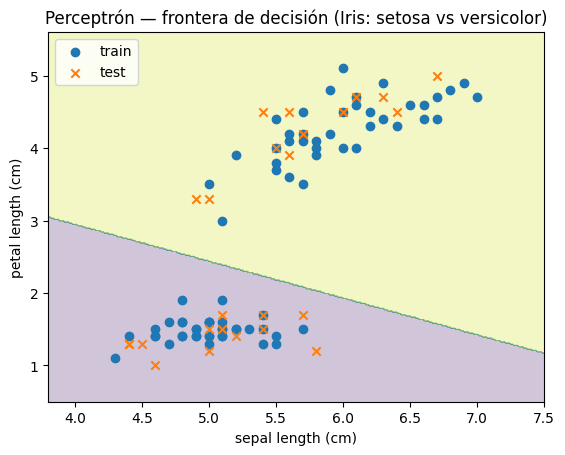

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Malla para la frontera
x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = perceptron_clf.predict(grid).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, alpha=0.25)  # sin especificar colores
plt.scatter(X_train[:,0], X_train[:,1], label="train")
plt.scatter(X_test[:,0], X_test[:,1], marker="x", label="test")
plt.xlabel("sepal length (cm)")
plt.ylabel("petal length (cm)")
plt.title("Perceptrón — frontera de decisión (Iris: setosa vs versicolor)")
plt.legend()
plt.show()


Interpretación de los resultados de *Model Evaluation*

El modelo obtuvo **Accuracy = 1.00** (100 %) y una **matriz de confusión perfecta**, sin errores de clasificación entre *setosa* y *versicolor*.  
Este resultado se explica por:

1. **Separabilidad lineal:** las dos clases están claramente separadas usando solo `sepal length (cm)` y `petal length (cm)`, por lo que un modelo lineal como el **Perceptrón** es suficiente.  
2. **Estandarización adecuada:** el uso de `StandardScaler` estabilizó el entrenamiento y ayudó a que el modelo convergiera correctamente.

**Lectura de las métricas:**  
- `Accuracy`: proporción total de aciertos.  
- `Precision`, `Recall`, `F1-Score`: valores iguales a 1.00 indican clasificación perfecta.  
- La **matriz de confusión** confirma la ausencia de falsos positivos o negativos.

**Limitaciones y buenas prácticas:**  
- Un 100 % de accuracy **no garantiza** que el modelo generalice en otros conjuntos de datos.  
- Se recomienda aplicar **validación cruzada (k-fold)**, incluir **más características o clases**, y analizar **curvas de aprendizaje** para comprobar la estabilidad del modelo.  
- En datos no linealmente separables, conviene usar regularización (`penalty='l2'`) o modelos no lineales como **SVM con kernel**.

> **En síntesis:** El Perceptrón ofrece un rendimiento perfecto en este escenario binario simple y lineal.  
> Para un análisis más riguroso, se sugiere validar su comportamiento con más variables, clases y métodos de evaluación cruzada.


## 3. Referencias bibliográficas

- F. Rosenblatt (1958). *The Perceptron: A probabilistic model for information storage and organization in the brain*. **Psychological Review**.  
- C. M. Bishop (2006). *Pattern Recognition and Machine Learning*. Springer. Cap. 4.  
- T. Hastie, R. Tibshirani, J. Friedman (2009). *The Elements of Statistical Learning*. Springer. Cap. 2/4.  
- Documentación de scikit-learn: **Perceptron**  
  <https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html>  
- Tutoriales y *User Guide* de scikit-learn (Model Evaluation, Pipelines):  
  <https://scikit-learn.org/stable/user_guide.html>
- Formulación matemática del Perceptrón | Interactive Chaos. (s. f.). https://interactivechaos.com/es/manual/tutorial-de-machine-learning/formulacion-matematica-del-perceptron

- Garau, G., & Garau, G. (2025, 21 octubre). El Perceptrón Simple: Implementación en Python. Damavis Blog - Data - Machine Learning - Visualization. https://blog.damavis.com/el-perceptron-simple-implementacion-en-python